## Delta Hedging with Transaction Costs: The Clewlow & Hodges Inaction Region

The purpose of this analysis is **not** to improve the classical
delta-hedging model with a more sophisticated volatility process.

Instead, the objective is to study how the introduction of an
**inaction region**, as proposed by Clewlow & Hodges, affects:

- the **frequency of rebalancing**,
- the **total transaction costs incurred**,
- the **hedging performance** of the option writer.

To make the simulated price dynamics reasonably realistic,
a GARCH model is used to generate time-varying volatility.
However, the central focus remains on the *behavioral change*
induced by the inaction region.


Shape del dataset: (251, 2)

Valori mancanti per colonna (prima della pulizia):
Ultimo     0
Returns    1
dtype: int64

Date lavorative mancanti: 9
DatetimeIndex(['2024-01-15', '2024-02-19', '2024-03-29', '2024-05-27',
               '2024-06-19', '2024-07-04', '2024-09-02', '2024-11-28',
               '2024-12-25'],
              dtype='datetime64[ns]', freq=None)

Date duplicate: 0


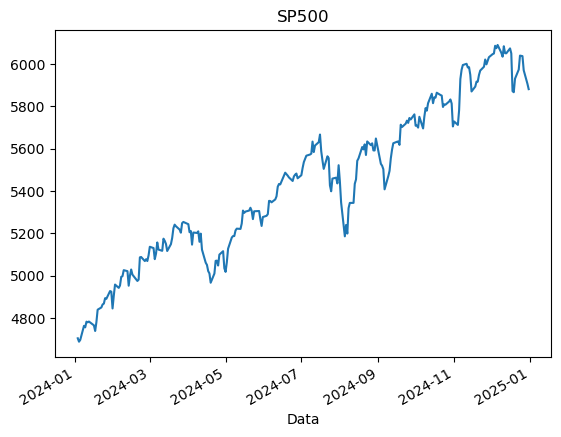

,Ultimo,Returns
Data,,
2024-01-03,4704.81,-0.008049
2024-01-04,4688.68,-0.003434
2024-01-05,4697.24,0.001824
2024-01-08,4763.54,0.014016
2024-01-09,4756.50,-0.001479


In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import norm

file_path = 'SP500_prices.csv'

# 1) Leggo il CSV SENZA convertire subito le date
df = pd.read_csv(file_path)

# 2) Converto la colonna 'Data' interpretando il formato italiano gg/mm/aaaa
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)  # se vuoi ancora più rigido: format="%d/%m/%Y"

# 3) Imposto 'Data' come indice e ordino dal più vecchio al più recente
df = df.set_index('Data').sort_index()

# 4) Mi assicuro che 'Ultimo' sia numerico
df['Ultimo'] = pd.to_numeric(df['Ultimo'], errors='coerce')

# 5) Calcolo i rendimenti logaritmici
df['Returns'] = np.log(df['Ultimo'] / df['Ultimo'].shift(1))

# 6) Controlli di qualità
missing_values = df.isna().sum()

date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
missing_dates = date_range.difference(df.index)

duplicates = df.index.duplicated().sum()

# 7) Pulizia finale
df = df.ffill().dropna()

# 8) Output riassuntivo
print("Shape del dataset:", df.shape)
print("\nValori mancanti per colonna (prima della pulizia):")
print(missing_values)
print("\nDate lavorative mancanti:", len(missing_dates))
print(missing_dates[:15])
print("\nDate duplicate:", duplicates)

# 9) Controllo visivo
df['Ultimo'].plot(title="SP500")
plt.show()

df.head()

## Overview of the Functions

This code block implements the core components of the model:  
(1) automatic volatility selection, (2) Black–Scholes pricing, and  
(3) delta-hedging with an inaction region in the presence of transaction costs.

---

### 1. Automatic GARCH Model Selection

The function `calculate_garch_volatility_auto()` automatically selects a volatility model for the return series.  

It estimates several specifications by combining:

- different volatility processes  
  (`Garch`, `EGarch`, `FIGARCH`, `APARCH`, `HARCH`);
- different conditional distributions  
  (`normal`, `t`, `skewt`, `ged`, `skewged`);
- multiple combinations of orders \( p \) and \( q \).

For each model, the function checks:

- whether all parameters are statistically significant (p-value < \( \alpha \)),
- the Akaike Information Criterion (AIC).

Selection rule:

1. If at least one specification has **all parameters significant**,  
   the model with the **lowest AIC among them** is chosen.
2. Otherwise, the model with **lowest AIC overall** is selected.

The output consists of:

- the conditional volatility series \( \sigma_t \),
- the fitted model object,
- the specification of the chosen model.

This provides a realistic, time-varying volatility input for simulations.

---

### 2. Black–Scholes Pricing and Delta

The functions `bs_call_price()` and `bs_delta_call()` compute:

- the theoretical price of a European call,
- the corresponding delta.

They use the standard Black–Scholes expressions:

$$
C = S \Phi(d_1) - K e^{-rT} \Phi(d_2), \qquad
\Delta = \Phi(d_1),
$$

where

$$
d_1 = \frac{\ln(S/K) + (r + \tfrac{1}{2}\sigma^2)T}{\sigma\sqrt{T}},
\qquad
d_2 = d_1 - \sigma\sqrt{T}.
$$

Both functions support vectorized inputs, so they can be applied across
many simulated paths simultaneously.

---

### 3. Delta Hedging with an Inaction Region

The function `rebalancing_with_inaction_bands()` implements delta hedging under
proportional transaction costs and follows the Clewlow & Hodges idea of an
**inaction region**.

At each time step:

1. the Black–Scholes delta is computed,
2. an inaction band is constructed:

$$
[\Delta_t - \Gamma k,\; \Delta_t + \Gamma k],
$$

3. the position is rebalanced **only if** the current hedge lies outside this band.

Inside the band, no trading occurs.

All trades generate both:

- a cash flow from buying/selling the underlying,
- a cost proportional to the traded notional.

The cash account accumulates continuously at the risk-free rate.

The function returns:

- the final cash balance (including all costs),
- the total number of rebalancings,
- the final delta position.

These outputs are subsequently used to compute the final P&L of the option writer
and study how the inaction region affects trading frequency and hedging performance.


In [46]:
def calculate_garch_volatility_auto(
    returns,
    max_p=2,
    max_q=2,
    alpha=0.05,
    vol_types=None,
    dists=None
):
    """
    Automatically selects a “best” GARCH-type volatility model for the return series.

    Logic:
    - Tests multiple combinations of:
        * volatility specifications: GARCH, EGARCH, FIGARCH, APARCH, HARCH (if supported)
        * distributions: normal, t, skewt, ged, skewged (if supported)
        * orders: p = 1..max_p, q = 1..max_q
    - Marks a model as "valid" if ALL parameters are statistically significant
      (p-value < alpha).
    - Among valid models, selects the one with the lowest AIC.
    - If no model has all significant parameters, selects the model with
      the lowest AIC among all successfully estimated models.

    Parameters
    ----------
    returns : pd.Series
        Time series of log-returns (without NaNs).
    max_p, max_q : int
        Maximum orders to try for p and q.
    alpha : float
        Significance threshold for parameter p-values.
    vol_types : list or None
        List of volatility model types to test.
        If None, a default broad set is used.
    dists : list or None
        List of conditional distributions to test.
        If None, a default broad set is used.

    Returns
    -------
    best_volatility : pd.Series
        Estimated conditional volatility series (σ_t) of the chosen model.
    best_model : arch.univariate.base.ARCHModelResult
        Fitted model object selected as the best.
    best_spec : dict
        Specification of the chosen model:
        {
            "vol": ...,
            "dist": ...,
            "p": ...,
            "q": ...,
            "aic": ...,
            "all_significant": True/False
        }
    """

    # Default: “all” model types and distributions we want to test
    if vol_types is None:
        vol_types = ["Garch", "EGarch", "FIGARCH", "APARCH", "HARCH"]

    if dists is None:
        dists = ["normal", "t", "skewt", "ged", "skewged"]

    # Remove any NaNs from the returns
    returns = returns.dropna()

    valid_models = []   # models with all parameters significant
    all_models = []     # all successfully estimated models

    for vol in vol_types:
        for dist in dists:
            for p in range(1, max_p + 1):
                for q in range(1, max_q + 1):
                    try:
                        am = arch_model(
                            returns,
                            vol=vol,
                            p=p,
                            q=q,
                            mean="Zero",
                            dist=dist
                        )
                        res = am.fit(disp="off")
                    except Exception:
                        # If the model is not implemented, does not converge, or fails,
                        # skip this specification
                        continue

                    aic = res.aic
                    pvalues = res.pvalues

                    # Are all parameters statistically significant?
                    all_significant = (pvalues < alpha).all()

                    model_info = {
                        "vol": vol,
                        "dist": dist,
                        "p": p,
                        "q": q,
                        "aic": aic,
                        "res": res,
                        "all_significant": all_significant
                    }

                    all_models.append(model_info)

                    if all_significant:
                        valid_models.append(model_info)

    # If no model was estimated successfully at all
    if len(all_models) == 0:
        raise RuntimeError("No GARCH model was successfully estimated.")

    # 1) If there are models with all significant parameters, choose the one with min AIC
    if len(valid_models) > 0:
        best = min(valid_models, key=lambda m: m["aic"])
        res_best = best["res"]
        best_volatility = res_best.conditional_volatility  # σ_t (already in standard deviation units)
        best_spec = {
            "vol": best["vol"],
            "dist": best["dist"],
            "p": best["p"],
            "q": best["q"],
            "aic": best["aic"],
            "all_significant": True
        }
        return best_volatility, res_best, best_spec

    # 2) Fallback: no model has all significant parameters
    best = min(all_models, key=lambda m: m["aic"])
    res_best = best["res"]
    best_volatility = res_best.conditional_volatility
    best_spec = {
        "vol": best["vol"],
        "dist": best["dist"],
        "p": best["p"],
        "q": best["q"],
        "aic": best["aic"],
        "all_significant": False
    }

    return best_volatility, res_best, best_spec


def bs_call_price(S, K, T, r, sigma):
    """
    Black–Scholes price of a European call option.

    Supports scalar or vector inputs for S and sigma.
    """
    S = np.asarray(S)
    sigma = np.asarray(sigma)
    T = np.maximum(T, 1e-8)  # avoid division by zero when T is very small

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def bs_delta_call(S, K, T, r, sigma):
    """
    Black–Scholes delta of a European call option.

    Returns the sensitivity of the call price with respect
    to changes in the underlying price.
    """
    S = np.asarray(S)
    sigma = np.asarray(sigma)
    T = np.maximum(T, 1e-8)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)


def rebalancing_with_inaction_bands(S, K, T, r, sigma_input, cost_rate, gamma_factor):
    """
    Delta-hedging with proportional transaction costs and an inaction region.

    Parameters
    ----------
    S : np.ndarray
        Simulated underlying prices, shape (M, N+1), where:
        - M = number of paths,
        - N = number of time steps.
    sigma_input : float or np.ndarray
        Volatility input, can be:
        - scalar       -> constant volatility,
        - array (N,)   -> same σ_t for all paths,
        - array (M, N) -> path-dependent σ_t (e.g. from GARCH simulations).
    K : float
        Strike price of the call.
    T : float
        Time to maturity (in years).
    r : float
        Risk-free rate.
    cost_rate : float
        Proportional transaction cost (e.g. 0.005 = 0.5% of underlying notional).
    gamma_factor : float
        Width parameter for the inaction band.

    Returns
    -------
    cash_with_costs : np.ndarray
        Final cash account values for each path, including all transaction costs.
    rebalancing_count : np.ndarray
        Number of rebalancings performed on each path.
    delta_prev : np.ndarray
        Final delta position at maturity for each path.
    """

    M, steps = S.shape
    N = steps - 1
    dt = T / N

    delta_prev = np.zeros(M)              # initial position in the underlying
    cash_with_costs = np.zeros(M)         # cash account (option premium is handled outside)
    rebalancing_count = np.zeros(M, dtype=int)

    for t in range(N):
        time_to_maturity = T - t * dt
        if time_to_maturity <= 0:
            break

        # 1) Compounding the cash account at the risk-free rate
        cash_with_costs *= np.exp(r * dt)

        # 2) Volatility: constant or time/path-dependent
        if np.ndim(sigma_input) == 0:
            sigma_t = sigma_input
        else:
            if sigma_input.ndim == 1:
                # same σ_t for all paths at time t
                sigma_t = sigma_input[t]
            else:
                # specific σ_t for each path at time t
                sigma_t = sigma_input[:, t]

        # 3) Black–Scholes delta at (S_t, time_to_maturity)
        delta_t = bs_delta_call(S[:, t], K, time_to_maturity, r, sigma_t)

        # 4) Inaction band shrinking as maturity approaches
        band_width = gamma_factor * cost_rate * np.sqrt(time_to_maturity / T)
        x_minus = delta_t - band_width
        x_plus  = delta_t + band_width

        should_rebalance = (delta_prev < x_minus) | (delta_prev > x_plus)

        # 5) Quantity of underlying to trade
        traded_amount = delta_t - delta_prev

        # Cash flow: buying (negative), selling (positive)
        cash_flow = - traded_amount * S[:, t]

        # Transaction cost proportional to traded notional
        trans_cost = cost_rate * np.abs(traded_amount) * S[:, t]

        # 6) Update cash account only where rebalancing occurs
        cash_with_costs += should_rebalance * (cash_flow - trans_cost)

        rebalancing_count += should_rebalance.astype(int)

        # 7) Update delta position
        delta_prev = np.where(should_rebalance, delta_t, delta_prev)

    # Return final cash, number of rebalancings, and final delta
    return cash_with_costs, rebalancing_count, delta_prev


c:\Users\kevin\anaconda3\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.35e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kevin\anaconda3\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.35e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kevin\anaconda3\lib\site-packages\arch\univariate\base.py:311: DataSc

Best model selected:
{'vol': 'EGarch', 'dist': 'ged', 'p': 1, 'q': 1, 'aic': -1723.1625371516334, 'all_significant': True}

Summary of the selected model:
                             Zero Mean - EGARCH Model Results                             
Dep. Variable:                            Returns   R-squared:                       0.000
Mean Model:                             Zero Mean   Adj. R-squared:                  0.004
Vol Model:                                 EGARCH   Log-Likelihood:                865.581
Distribution:      Generalized Error Distribution   AIC:                          -1723.16
Method:                        Maximum Likelihood   BIC:                          -1709.06
                                                    No. Observations:                  251
Date:                            Sun, Dec 28 2025   Df Residuals:                      251
Time:                                    19:59:07   Df Model:                            0
                          

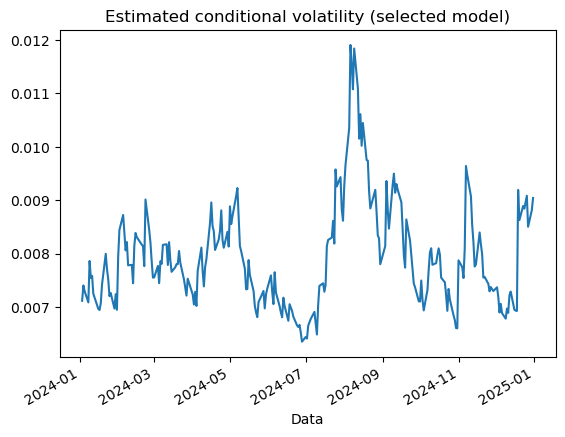

Average GARCH volatility (sigma): 0.007942017118298946


In [47]:
returns = df['Returns'].dropna()

# Automatically select the best GARCH-type volatility model
garch_vol, garch_model, garch_spec = calculate_garch_volatility_auto(
    returns,
    max_p=2,
    max_q=2,
    alpha=0.05
)

print("Best model selected:")
print(garch_spec)

print("\nSummary of the selected model:")
print(garch_model.summary())

# Plot the estimated conditional volatility
garch_vol.plot(title="Estimated conditional volatility (selected model)")
plt.show()

# Average volatility used later as a fallback / comparison value
sigma = float(garch_vol.mean())
print("Average GARCH volatility (sigma):", sigma)


## Simulation Framework

The simulation consists of two main stages:

1. generating stochastic volatility paths from the estimated GARCH model;
2. using these volatility paths inside a Monte Carlo simulation of the underlying asset.

---

### Step 1 — Simulation Parameters

The following assumptions are imposed:

- initial price: \( S_0 \)
- time to maturity: \( T = 1 \) year
- risk-free rate: \( r = 0.02 \)
- number of time steps: \( N = 252 \)
- number of simulated paths: \( M = 10{,}000 \)

This configuration allows us to evaluate the hedging strategy across a wide range
of possible price scenarios.

---

### Step 2 — GARCH-Driven Volatility

The previously estimated GARCH model is used to simulate conditional volatility
and return shocks. For each simulated path we obtain:

- a series of conditional volatilities \( \sigma_t \),
- the associated simulated returns \( r_t \).

These are stored in matrices of dimensions \( (M \times N) \):

$$
\sigma_{\text{path}} = [\sigma_{t}^{(i)}], \qquad
r_t = [r_{t}^{(i)}].
$$

This procedure produces a **time-varying**, path-dependent volatility process.

---

### Step 3 — Monte Carlo Simulation of Prices

The simulated dynamics of the underlying follow:

$$
S_{t+1}
=
S_t
\exp\!\left[
\left(
r - \frac{1}{2}\sigma_t^2
\right)\Delta t
+
\sigma_t \sqrt{\Delta t}\, Z_t
\right],
$$

where:

- $Z_t \sim \mathcal{N}(0,1) $,
- $ \sigma_t $ is taken directly from the GARCH simulation.

This yields the simulated price matrix:

$$
S = \{ S_t^{(i)} \}, \qquad S \in \mathbb{R}^{M \times (N+1)} ,
$$

which forms the basis for evaluating the delta-hedging strategies
in the later sections.


In [ ]:
# --- 1) Simulation parameters ---
S0 = df['Ultimo'].iloc[-1]   # most recent price
T = 1.0                      # maturity (years)
r = 0.02                     # risk-free rate
N = 252                      # number of time steps
M = 10000                    # number of simulated paths

# --- 2) (already done earlier) GARCH estimation ---
# garch_model = ...

# --- 3) GARCH simulation: generate paths of conditional volatility ---
simulated_vols = []
simulated_returns = []

for i in range(M):
    sim_i = garch_model.model.simulate(garch_model.params, nobs=N)
    simulated_vols.append(sim_i["volatility"])
    simulated_returns.append(sim_i["data"])

sigma_path = np.array(simulated_vols)    # shape (M, N)
r_t = np.array(simulated_returns)        # shape (M, N)

print("sigma_path shape:", sigma_path.shape)

# --- 4) Monte Carlo simulation of the underlying (using sigma_path) ---
dt = T / N
S = np.zeros((M, N + 1))
S[:, 0] = S0

for t in range(1, N + 1):
    sigma_t = sigma_path[:, t-1]        # volatility for each path at step t
    Z = np.random.standard_normal(M)    # i.i.d. shocks

    S[:, t] = S[:, t-1] * np.exp(
        (r - 0.5 * sigma_t**2) * dt + sigma_t * np.sqrt(dt) * Z
    )


sigma_path shape: (10000, 252)


## Simulated Paths of the Underlying Asset

The figure below displays a subset of the Monte Carlo simulations generated for the
underlying price. For visual clarity, only the first 100 simulated trajectories
are shown.

Each trajectory evolves according to the stochastic process:

$$
S_{t+1}
=
S_t
\exp\!\left[
\left(
r - \frac{1}{2}\sigma_t^2
\right)\Delta t
+
\sigma_t \sqrt{\Delta t}\, Z_t
\right],
$$

where \( \sigma_t \) is the GARCH-driven conditional volatility.

The dashed horizontal lines indicate the strike levels used in the option-pricing
and hedging experiments. These reference levels help to visualise how frequently
the simulated price paths finish:

- in-the-money,
- at-the-money,
- or out-of-the-money.

This plot provides intuition about the distribution and dispersion of simulated
terminal prices, which is essential for interpreting the hedging results that
follow.


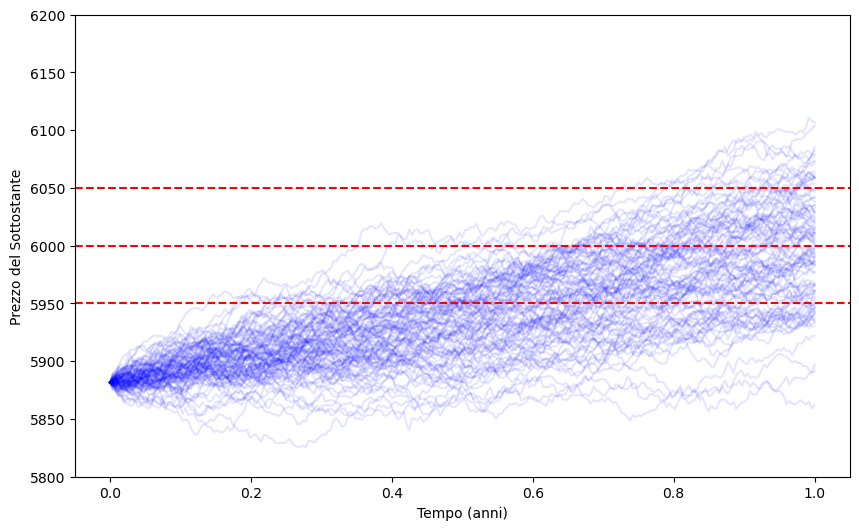

In [ ]:
# Plot simulated price paths
plt.figure(figsize=(10, 6))

# Show only the first 100 simulated trajectories for visualization
for i in range(100):
    plt.plot(np.linspace(0, T, N+1), S[i, :], alpha=0.1, color='blue')

# Display strike levels as horizontal lines
plt.ylim(5800, 6200)
plt.axhline(y=strike_prices[0], color='r', linestyle='--')
plt.axhline(y=strike_prices[1], color='r', linestyle='--')
plt.axhline(y=strike_prices[2], color='r', linestyle='--')

plt.xlabel('Time (years)')
plt.ylabel('Underlying price')

plt.title('Simulated underlying price paths')
plt.show()


In [48]:
for K in strike_prices:
    for cost_rate in cost_rates:
        # 1) Hedging with time-varying σ_t from the GARCH model
        cash_with_costs, rebalancing_count, delta_final = rebalancing_with_inaction_bands(
            S=S,
            K=K,
            T=T,
            r=r,
            sigma_input=sigma_path,      # path-dependent volatility
            cost_rate=cost_rate,
            gamma_factor=gamma_factor
        )

        # 2) Initial call premium (short call: the writer receives it)
        # S0 is scalar, sigma0 is an "average" initial volatility estimate
        sigma0 = float(np.mean(sigma_path[:, 0]))
        option_price0 = bs_call_price(S0, K, T, r, sigma0)   # scalar

        # 3) Call payoff at maturity
        final_payoff_call = np.maximum(S[:, -1] - K, 0)

        # 4) Final P&L of the strategy (short call + hedging)
        #   initial premium + cash (with costs) + final underlying position – call payoff
        portfolio_final = option_price0 + cash_with_costs + delta_final * S[:, -1] - final_payoff_call

        # 5) Probabilities
        prob_profit = np.mean(portfolio_final > 0)
        exercise_probability = np.mean(final_payoff_call > 0)

        print(f"\nStrike price: {K}, Transaction cost: {cost_rate*100:.2f}%")
        print(f"Average number of rebalancings: {int(np.mean(rebalancing_count))}")
        print(f"Exercise probability of the call: {exercise_probability:.4f}")
        print(f"Probability that the hedging strategy is profitable: {prob_profit:.4f}")


Strike price: 5950, Transaction cost: 0.00%
Average number of rebalancings: 245
Exercise probability of the call: 0.8534
Probability that the hedging strategy is profitable: 0.2674

Strike price: 5950, Transaction cost: 0.50%
Average number of rebalancings: 71
Exercise probability of the call: 0.8534
Probability that the hedging strategy is profitable: 0.0000

Strike price: 5950, Transaction cost: 1.00%
Average number of rebalancings: 38
Exercise probability of the call: 0.8534
Probability that the hedging strategy is profitable: 0.0000

Strike price: 5950, Transaction cost: 1.50%
Average number of rebalancings: 25
Exercise probability of the call: 0.8534
Probability that the hedging strategy is profitable: 0.0000

Strike price: 6000, Transaction cost: 0.00%
Average number of rebalancings: 250
Exercise probability of the call: 0.5020
Probability that the hedging strategy is profitable: 0.4358

Strike price: 6000, Transaction cost: 0.50%
Average number of rebalancings: 115
Exercise pro

## Interpretation of Hedging Results

The simulation results allow us to evaluate the performance of the
Clewlow–Hodges inaction-region strategy when proportional transaction costs
are present.

---

### Profitability and Transaction Costs

When transaction costs are set to \( 0\% \), the strategy shows a non-negligible probability of generating a positive profit-and-loss for the option writer. In this frictionless setting, the hedge can replicate the option reasonably well, and the absence of trading costs prevents losses from accumulating.

Once positive transaction costs are introduced, the picture changes substantially. Even relatively small values result in outcomes where the writer’s final P&L is almost always negative. The strategy continues to rebalance frequently, while the framework itself does not explicitly optimise against the cost of maintaining such activity.

In practice, the cumulative cost of trading dominates the premium received at initiation, rendering the strategy economically unsustainable:

$$
\text{P\&L}_T
=
C_0
+
\text{cash}_T
+
\Delta_T S_T
-
(S_T - K)^+,
$$

where the cash account \( \text{cash}_T \) absorbs progressively larger trading
costs as rebalancing continues. Although the number of rebalancings does fall
relative to the zero-transaction-cost case, this reduction is insufficient to
offset trading frictions. As a consequence, the final outcome is, in most cases,
a loss for the writer.

Overall, while the inaction region successfully reduces unnecessary trades, it does not, in its basic form, provide a fully sustainable hedging strategy once realistic transaction costs are taken into account.


---

### Probability of Exercise

An important observation is that the **probability of exercise** remains
unchanged across all cost scenarios. Formally,

$$
\mathbb{P}(S_T > K)
$$

depends only on the simulated dynamics of the underlying price and the strike
level. Since the price process is exogenous in our framework, the hedging
strategy — including how often we rebalance — does **not** influence whether
the option finishes in-the-money.

This is consistent with the viewpoint of the option writer: hedging alters
risk exposure but cannot alter the terminal payoff structure of the option.

---

### Overall Assessment

The analysis suggests that the Clewlow–Hodges inaction interval provides a
conceptually appealing mechanism for reducing excessive rebalancing.
Nevertheless, when realistic trading frictions are introduced, the strategy
may become economically unattractive:

- transaction costs accumulate quickly,
- profits vanish,
- the strategy cannot systematically outperform the option payoff structure.

In summary, the inaction-region approach highlights the trade-off between
hedging precision and trading costs, but — in its basic form — it does not
fully account for how expensive it is to maintain such a strategy in real
markets.
